In [97]:
import pandas as pd

df_ae = pd.read_csv("../data/atitudesEducadores_df.csv", index_col=0)
df_pp = pd.read_csv("../data/praticasprofissionais_df.csv", index_col=0)

Primeiro, analisamos a possibilidade de cruzar as duas bases de dados.


In [98]:
common_cols = (set(df_ae.columns) & set(df_pp.columns)) - set(["tempo", "termo"])

# df_pp[common_cols].replace("\n", " ", regex=True).replace('(^\s+|\s+$)', '', regex=True).to_csv("pp.csv", index=False)
# df_ae[common_cols].replace("\n", " ", regex=True).replace('(^\s+|\s+$)', '', regex=True).to_csv("ae.csv", index=False)


Após gerar novos arquivos CSV sem quebras de linha nos campost string e contendo apenas colunas comuns às duas bases, foi detectado um número muito pequeno de linhas idênticas entre as duas bases (n = 44). Algumas linhas eram praticamente idênticas com, por exemplo, pequenas mudanças de grafia entre atributos. Portanto, a integração das bases para fins de análise foi descartada. Exemplo:

|     |            |                        |          |         |            |     |                      |     |
| --- | ---------- | ---------------------- | -------- | ------- | ---------- | --- | -------------------- | --- |
| Sim | Casado (a) | Força Aérea Brasileira | NaN      | 12 anos | evangelico | 35  | licenciado em música | ... |
| Sim | Casado (a) | Força Aérea Brasileira | trabalho | 12      | evangelico | 35  | licenciado em musica | ... |


### Observações

- Algumas pessoas (n < 43) marcaram "Outros" como `estadocivil` quando deveriam ter marcado "Solteiro" ou "Casado" (ex: pessoas 'amasiadas').

  - Duas pessoas marcaram "União Estável" na questão aberta e "Solteiro" na questão fechada. Será que existem outros erros semelhantes pela base?
  - Na verdade, outras colunas que permitem a resposta "Outros" podem ter sido respondidas erroneamente (ex: meio de contato com usuários de droga).
  - Em caso de respostas fechadas e abertas contraditórias, dar preferência à resposta aberta.

- `motivocurso`: aparentemente, muitas pessoas gostariam de marcar múltiplas alternativas. Poderíamos considerar a questão fechada como o motivo principal, mas essa suposição depende da pergunta exata que foi exibida para o usuário.

- `lida.onde`: com essa coluna, ocorre o mesmo problema mencionado logo acima. Porém, pode ser difícil para alguém definir o seu "meio de contato" principal.

- `ocupacao`: mesmo problema mencionado acima. Há profissionais que exercem múltiplas funções ao mesmo tempo. Há também aqueles que acabaram de mudar de cargo.

- `nomeservico`: algumas pessoas interpretaram isso como o nome do cargo, outras como o local de trabalho.

- `tempodeservico`: nas respostas escritas por extenso, algumas delas discriminaram o tempo de trabalho em cada lugar. Quantos dos números dessa coluna se referem ao tempo total de trabalho? Quantas se referem ao tempo de trabalho no último cargo?

- Existem entradas duplicadas na base PP.

### Perguntas Interessantes

- Porcentagem de pessoas que responderam duas vezes a mesma coisa.

- Análise da consistência das respostas. Das pessoas que adicionaram detalhes em 'outros', quantas delas discordaram do significado da opção fechada que marcaram?

In [99]:
# Exemplo de repetição.

df_pp[df_pp["nomeservico"].replace({np.nan: ""}).str.contains("Elitte")][df_pp.columns[:-39]]

,estado,iniciado,completo,tempo,termo,idade,sexo,escolaridade,estadocivil,estadocivil.outros,...,lidadiretamente,lida.onde,lida.outros,motivocurso,motivo.outros,materialdidatico,prazoatividades,interacaopares,organizacaocurso,import.ajud.tutor
1155,Finalizadas,6 junho 2014 16:11,6 junho 2014 16:28,17 minutos 4 segundos,Sim,41 anos,Feminino,Pós-graduação,Casado (a),NaN,...,Não,NaN,NaN,Identificação profissional com o tema,NaN,Adequado,Flexível,Importante,Organizado,Às vezes
1170,Finalizadas,6 junho 2014 16:51,6 junho 2014 17:04,12 minutos 42 segundos,Sim,41,Feminino,Pós-graduação,Casado (a),NaN,...,Não,NaN,NaN,Identificação profissional com o tema,NaN,Adequado,Flexível,Importante,Organizado,Às vezes


In [100]:
df_ae[df_ae["estadocivil"] == "Outros"]["estadocivil.outros"].unique()


array(['casada no religioso', 'Casamento Religioso', 'separado(a)',
       'Noiva', nan, 'separada', 'AMASIADA', 'separada judicialmente',
       'Separado judicialmente', 'divorciada e nova uniao atualmente',
       'casada na Igreja', 'solteiro', 'namorando',
       'separado não judicialmente', 'Moro com um companheiro',
       'Separada', 'vivo com um companheiro', 'separado judicialmente',
       'moro com companheiro', 'SEPARADO',
       'Sou casada, porém sem casamento comprobatório', 'amasiada',
       'Separado mais não no papel', 'separado não no letigioso',
       'SEPARADA', 'moro com meu marido.', 'Moro  junto', 'casada',
       'divorciando', 'noiva', 'Separado Judicialmente.',
       'Moro com uma pessoa', 'amaziada há 10 anos'], dtype=object)

## Base Atitudes Educadores


In [101]:
# Filtragem de COLUNAS que não serão analisadas;

df_ae = df_ae.drop(
    [
        "X",  # é igual ao índice
        "tempo",  # (o que é?) dado não aparenta significar nada relevante
        "termo",  # (o que é?) dado não aparenta significar nada relevante
        "nome.completo",  # apenas NaN
        "rg",  # apenas NaN
        "e.mail.1",  # apenas NaN
        # algumas pessoas interpretaram como nome do cargo. Outras, como nome do local de trabalho.
        "nomeservico",
        # "ocupacao.outra"
    ],
    axis=1,
)


In [102]:
# FILTRAGEM DE LINHAS

# Remover linhas totalmente vazias
df_ae = df_ae.dropna(how="all")
df_ae.replace("\n", " ", regex=True, inplace=True)


In [103]:
YEAR = 2014

# Recuperar campos escritos por extenso ou incorretamente.
df_ae["idade"] = (
    df_ae["idade"]
    .replace("(\s)*(?i)ano[s]?(\s)*", "", regex=True)
    .replace("\.", "", regex=True)
    .replace("quarenta e dois", 42)
    .replace("15´05 1975", YEAR - 1975)
    .replace("VINTE E SEIS", 26)
    .replace("trinta e seis", 36)
    .replace("1966/48", YEAR - 1966)
    .replace("1981", YEAR - 1981)
    .replace("1973", YEAR - 1973)
    .replace("23/06/1958", YEAR - 1958)
    .replace("1971", YEAR - 1971)
    .replace("cinquenta e três", 53)
    .replace("trinta e nove", 39)
    .replace("trinta e cinco", 35)
    .replace("19/02/1975 39", 39)
    .replace("55de idade", 55)
    .replace("dezenove", 19)
    .replace("vinte e nove", 29)
    .replace("cinquenta e um", 51)
    .replace("sesseta seis", 66)
    .replace("cinquenta", 50)
    .replace('"cinquenta"', 50)
    .replace("sessenta", 60)
    .replace("26 vinte e seis", 26)
    .replace("1966", YEAR - 1966)
    .replace("1961", YEAR - 1961)
    .replace("1975", YEAR - 1975)
    .replace("1964", YEAR - 1964)
    .replace("28/05/1963", YEAR - 1963)
    .replace("15/05/1975", YEAR - 1975)
    .replace("29/09/969", YEAR - 1969)
    .replace("1963", YEAR - 1963)
    .replace("1954", YEAR - 1954)
    .replace("vinte e quatro 24", 24)
    .replace("1958 56", 56)
    .replace("1985", YEAR - 1985)
    .replace("1972", YEAR - 1972)
    .replace("1974", YEAR - 1974)
    .replace("1958", YEAR - 1958)
    .replace("1977", YEAR - 1977)
    .replace("40 e 8", 48)
    .replace("trinta enove", 39)
    .replace("44a", 44)
    .replace("61de idade", 61)
    .replace("trinta e dois", 32)
    .replace("Quarenta e quatro", 44)
    .replace("cinquenta e dois", 52)
    .replace("trinta e oito", 38)
    .replace("quarenta e um", 41)
    .replace("cinquenta e nove", 59)
    .replace("24 vinte e quatro", 24)
    .replace("quarenta e nove", 49)
    .replace("vinte e sete", 27)
    .replace("quarenta e quatro", 44)
    .replace("trinta e sete", 37)
    .replace("quarenta", 40)
    .replace("trinta", 30)
    .replace("trinta e um", 31)
    .replace("vinte e seis", 26)
    .replace("dez", 10)
)

df_ae.loc[df_ae["idade"].notna(), "idade"] = df_ae[df_ae["idade"].notna()]["idade"].map(
    int
)
df_ae["idade"] = df_ae["idade"].astype(float)

# Remover outliers
# Provavelmente erros de digitação e respostas de outros campos de pergunta, a julgar pelos outros campos.
df_ae.loc[df_ae["idade"] < 18, "idade"] = None
df_ae.loc[df_ae["idade"] > 100, "idade"] = None

df_ae["idade"].describe()


count    3018.000000
mean       40.605699
std         8.955619
min        18.000000
25%        33.000000
50%        40.000000
75%        47.000000
max        70.000000
Name: idade, dtype: float64

In [104]:
import numpy as np

NUMS = [
    "um",
    "dois",
    "três",
    "quatro",
    "cinco",
    "seis",
    "sete",
    "oito",
    "nove",
    "dez",
    "onze",
    "doze",
    "treze",
    "quatorze",
    "quinze",
    "dezesseis",
    "dezessete",
    "dezoito",
    "dezenove",
    "vinte",
    "vinte e um",
    "vinte e dois",
    "vinte e três",
    "vinte e quatro",
    "vinte e cinco",
    "vinte e seis",
    "vinte e sete",
    "vinte e oito",
    "vinte e nove",
    "trinta",
    "trinta e um",
    "trinta e dois",
    "trinta e três",
    "trinta e quatro",
    "trinta e cinco",
    "trinta e seis",
    "trinta e sete",
    "trinta e oito",
    "trinta e nove",
    "quarenta",
    "quarenta e um",
    "quarenta e dois",
    "quarenta e três",
    "quarenta e quatro",
    "quarenta e cinco",
    "quarenta e seis",
    "quarenta e sete",
    "quarenta e oito",
    "quarenta e nove",
    "cinquenta",
    "cinquenta e um",
    "cinquenta e dois",
    "cinquenta e três",
    "cinquenta e quatro",
    "cinquenta e cinco",
    "cinquenta e seis",
    "cinquenta e sete",
    "cinquenta e oito",
    "cinquenta e nove",
    "sessenta",
    "sessenta e um",
    "sessenta e dois",
    "sessenta e três",
    "sessenta e quatro",
    "sessenta e cinco",
    "sessenta e seis",
    "sessenta e sete",
    "sessenta e oito",
    "sessenta e nove",
    "setenta",
    "setenta e um",
    "setenta e dois",
    "setenta e três",
    "setenta e quatro",
    "setenta e cinco",
    "setenta e seis",
    "setenta e sete",
    "setenta e oito",
    "setenta e nove",
    "oitenta",
    "oitenta e um",
    "oitenta e dois",
    "oitenta e três",
    "oitenta e quatro",
    "oitenta e cinco",
    "oitenta e seis",
    "oitenta e sete",
    "oitenta e oito",
    "oitenta e nove",
    "noventa",
    "noventa e um",
    "noventa e dois",
    "noventa e três",
    "noventa e quatro",
    "noventa e cinco",
    "noventa e seis",
    "noventa e sete",
    "noventa e oito",
    "noventa e nove",
    "cem",
]

# ATENÇÃO: interpretação pode ter variado de acordo com o respondente.
# Alguns podem ter interpretado como o tempo do último serviço; e outros o total.
# A coluna está enviesada (serve apenas para inferência em caso de correlação relevante).
# As perguntas não estavam claras

df_ae["tempodeservico"].replace("[aA][nN][oO][sS]?", "", regex=True, inplace=True)
df_ae["tempodeservico"].replace("\s*$", "", regex=True, inplace=True)
for x, text in enumerate(NUMS):
    df_ae["tempodeservico"].replace(
        f"^(?i){text}$", str(x + 1), regex=True, inplace=True
    )
df_ae["tempodeservico"].replace(
    "^\s*([0-9,]+)\s*[aA][nN][oO][sS]?\s*$", "\\1", regex=True, inplace=True
)
df_ae["tempodeservico"].replace("([0-9]),([0-9])", "\\1.", regex=True, inplace=True)
df_ae["tempodeservico"].replace(
    "^[0-9]+\s*[mM][eE][sS][eE][sS]$", 0, regex=True, inplace=True
)

# Inválidos.
df_ae["tempodeservico"] = (
    df_ae["tempodeservico"].replace("^.*[^0-9].*$", np.nan, regex=True).astype(float)
)

df_ae.loc[df_ae["tempodeservico"] > 1000, "tempodeservico"] = np.nan
df_ae.loc[df_ae["tempodeservico"] > df_ae["idade"], "tempodeservico"] = np.nan

df_ae["tempodeservico"].describe()


count    2873.000000
mean       12.455969
std         8.740747
min         0.000000
25%         5.000000
50%        11.000000
75%        19.000000
max        59.000000
Name: tempodeservico, dtype: float64

A extração de categorias de formação se mostrou muito complicada, então a ideia foi paralisada para essa entrega do trabalho.


In [105]:
# Formação

import re

pattern = re.compile("(?i)hist[oó]ria")
pattern = re.compile("(?i)matem[aá]tica")
pattern = re.compile("(?i)letras")
pattern = re.compile("(?i)ci[eê]ncias soci")
pattern = re.compile("(?i)sociologia")

# historia = 0
# for x in df_ae["formacao"].unique():
#     if type(x) != str:
#         continue
#     if re.search(pattern, x):
#         historia += 1


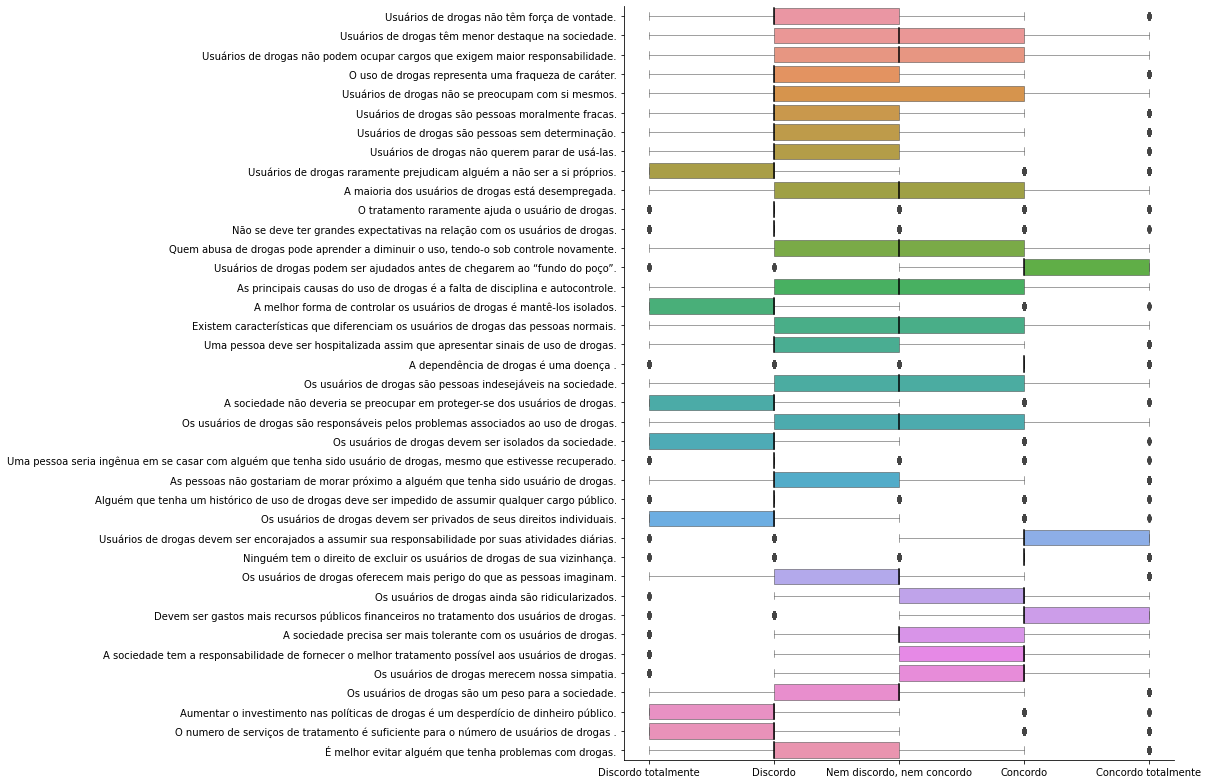

In [106]:
import seaborn as sns

questions = pd.read_csv("../data/percepcaosocial_questions.csv")

data = df_ae.iloc[:, -39:].replace(
    {
        "Discordo totalmente": 0,
        "Discordo": 1,
        "Nem discordo, nem concordo": 2,
        "Concordo": 3,
        "Concordo totalmente": 4,
    }
)
df_ae.iloc[:, -39:] = data

data.columns = [questions.iloc[x, 0] for x in range(len(data.columns))]
g = sns.catplot(
    data=data - 2,
    height=11,
    aspect=1.5,
    kind="box",
    orient="h",
    linewidth=0.5,
    medianprops={"linewidth": 1.5, "color": "black"},
)
# g.axes[0, 0].set_xlabel("Nível de Concordância")
g.axes[0, 0].set_xticks(np.arange(-2, 2.01, 1.0))
g.axes[0, 0].set_xticklabels(
    [
        "Discordo totalmente",
        "Discordo",
        "Nem discordo, nem concordo",
        "Concordo",
        "Concordo totalmente",
    ]
)

g.savefig("../figures/perguntas_boxplot.pdf")


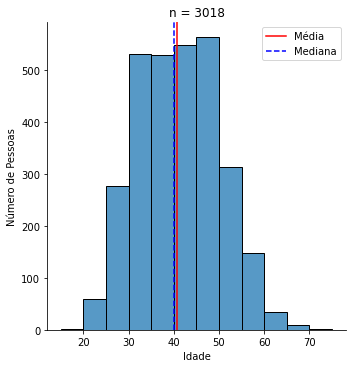

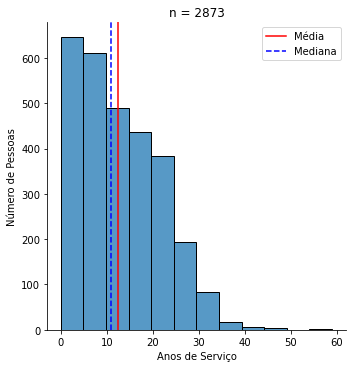

In [107]:
# GRAFICOS

# Idade
g = sns.displot(data=df_ae["idade"], bins=12, kind="hist", binrange=[15, 75])
g.axes[0, 0].set_xlabel("Idade")
g.axes[0, 0].set_ylabel("Número de Pessoas")
g.axes[0, 0].set_title(f"n = {df_ae['idade'].count()}")
g.axes[0, 0].axvline(x=df_ae["idade"].mean(), color="red")
g.axes[0, 0].axvline(x=df_ae["idade"].median(), color="blue", ls="--")
g.axes[0, 0].legend(["Média", "Mediana"])
g.savefig("../figures/idade_hist.pdf")

# Tempo de Serviço
g = sns.displot(data=df_ae["tempodeservico"], kind="hist", bins=12)
g.axes[0, 0].set_xlabel("Anos de Serviço")
g.axes[0, 0].set_ylabel("Número de Pessoas")
g.axes[0, 0].set_title(f"n = {df_ae['tempodeservico'].count()}")
g.axes[0, 0].axvline(x=df_ae["tempodeservico"].mean(), color="red")
g.axes[0, 0].axvline(x=df_ae["tempodeservico"].median(), color="blue", ls="--")
g.axes[0, 0].legend(["Média", "Mediana"])
g.savefig("../figures/tempodeservico_hist.pdf")


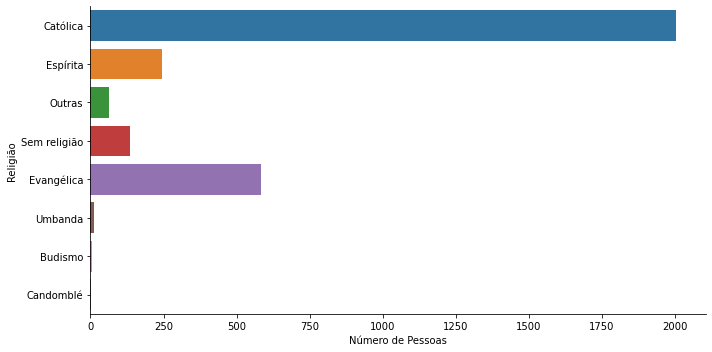

In [108]:
data = df_ae[df_ae["religiao"].notna()]
g = sns.catplot(data=data, y="religiao", kind="count", aspect=2)
g.axes[0, 0].set_ylabel("Religião")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/religiao.pdf")


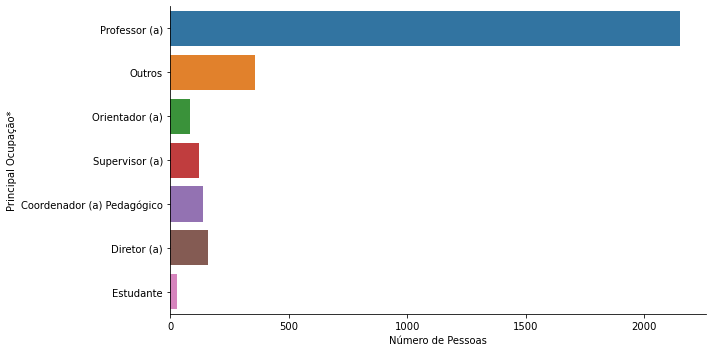

In [109]:
data = df_ae[df_ae["ocupacao"].notna()]
g = sns.catplot(data=data, y="ocupacao", kind="count", aspect=2)
g.axes[0, 0].set_ylabel("Principal Ocupação*")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/ocupacao.pdf")


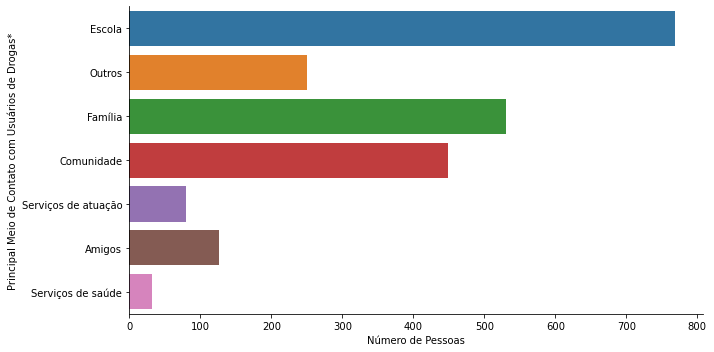

In [110]:
data = df_ae[df_ae["lida.onde"].notna()]
g = sns.catplot(data=data, y="lida.onde", kind="count", aspect=2)
g.axes[0, 0].set_ylabel("Principal Meio de Contato com Usuários de Drogas*")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/lidaonde.pdf")


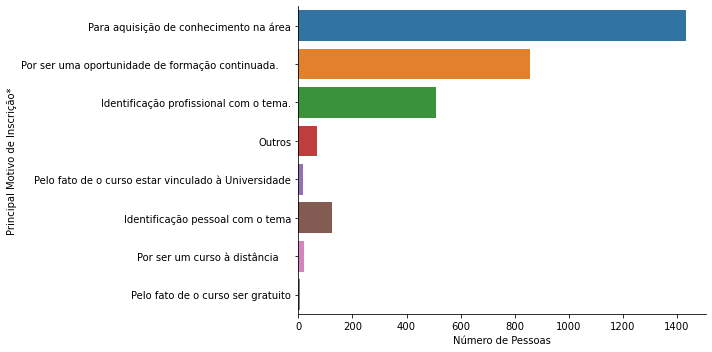

In [111]:
data = df_ae[df_ae["motivocurso"].notna()]
g = sns.catplot(data=data, y="motivocurso", kind="count", orient="h", aspect=2)
g.axes[0, 0].set_ylabel("Principal Motivo de Inscrição*")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/motivocurso.pdf")


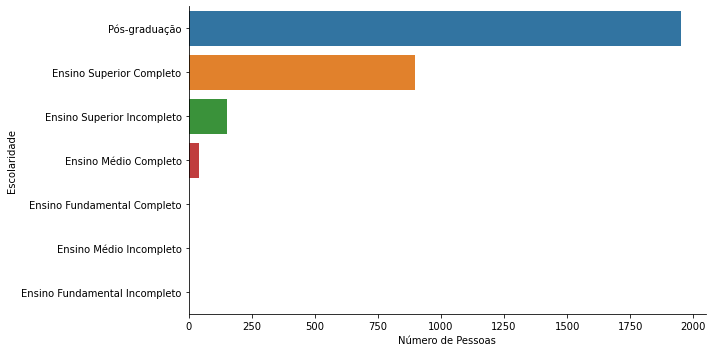

In [112]:
data = df_ae[df_ae["escolaridade"].notna()]
g = sns.catplot(data=data, y="escolaridade", kind="count", orient="h", aspect=2)
g.axes[0, 0].set_ylabel("Escolaridade")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/escolaridade.pdf")


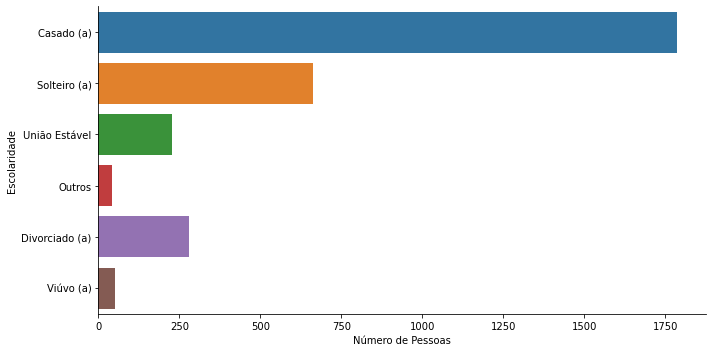

In [113]:
data = df_ae[df_ae["estadocivil"].notna()]
g = sns.catplot(data=data, y="estadocivil", kind="count", orient="h", aspect=2)
g.axes[0, 0].set_ylabel("Escolaridade")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/estadocivil.pdf")


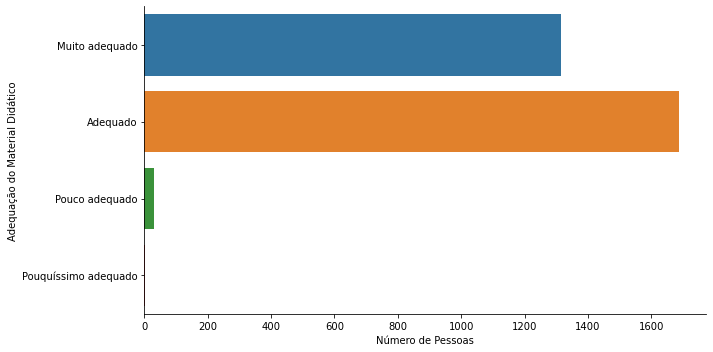

In [114]:
df_ae["materialdidatico"].replace(
    {"Adequado   \xa0": "Adequado", "Pouco adequado   \xa0": "Pouco adequado"},
    inplace=True,
)
data = df_ae[df_ae["materialdidatico"].notna()]
g = sns.catplot(data=data, y="materialdidatico", kind="count", orient="h", aspect=2)
g.axes[0, 0].set_ylabel("Adequação do Material Didático")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/materialdidatico.pdf")


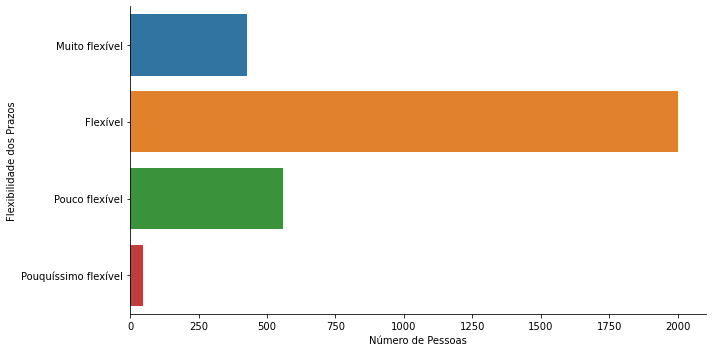

In [115]:
data = df_ae[df_ae["prazoatividades"].notna()]
g = sns.catplot(
    data=data,
    y="prazoatividades",
    kind="count",
    orient="h",
    aspect=2,
    order=["Muito flexível", "Flexível", "Pouco flexível", "Pouquíssimo flexível"],
)
g.axes[0, 0].set_ylabel("Flexibilidade dos Prazos")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/prazoatividades.pdf")


array(['Importante   \xa0', 'Pouco importante   \xa0', 'Muito importante',
       'Pouquíssimo importante', nan], dtype=object)

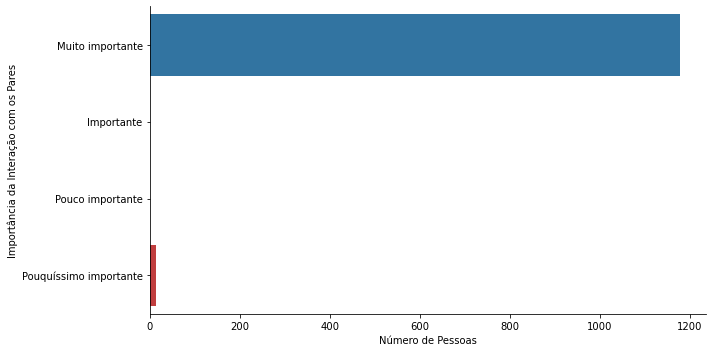

In [116]:
data = df_ae[df_ae["interacaopares"].notna()]
g = sns.catplot(
    data=data,
    y="interacaopares",
    kind="count",
    aspect=2,
    order=[
        "Muito importante",
        "Importante",
        "Pouco importante",
        "Pouquíssimo importante",
    ],
)
g.axes[0, 0].set_ylabel("Importância da Interação com os Pares")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/interacaopares.pdf")

df_ae["interacaopares"].unique()


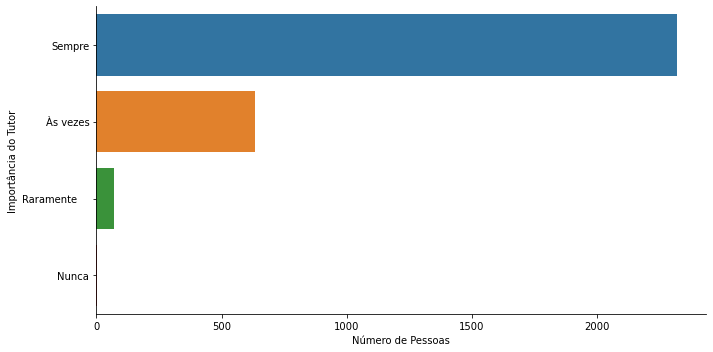

In [117]:
data = df_ae[df_ae["import.ajud.tutor"].notna()]
g = sns.catplot(
    data=data,
    y="import.ajud.tutor",
    kind="count",
    aspect=2,
    order=["Sempre", "Às vezes", "Raramente   \xa0", "Nunca"],
)
g.axes[0, 0].set_ylabel("Importância do Tutor")
g.axes[0, 0].set_xlabel("Número de Pessoas")
g.savefig("../figures/import.ajud.tutor.pdf")


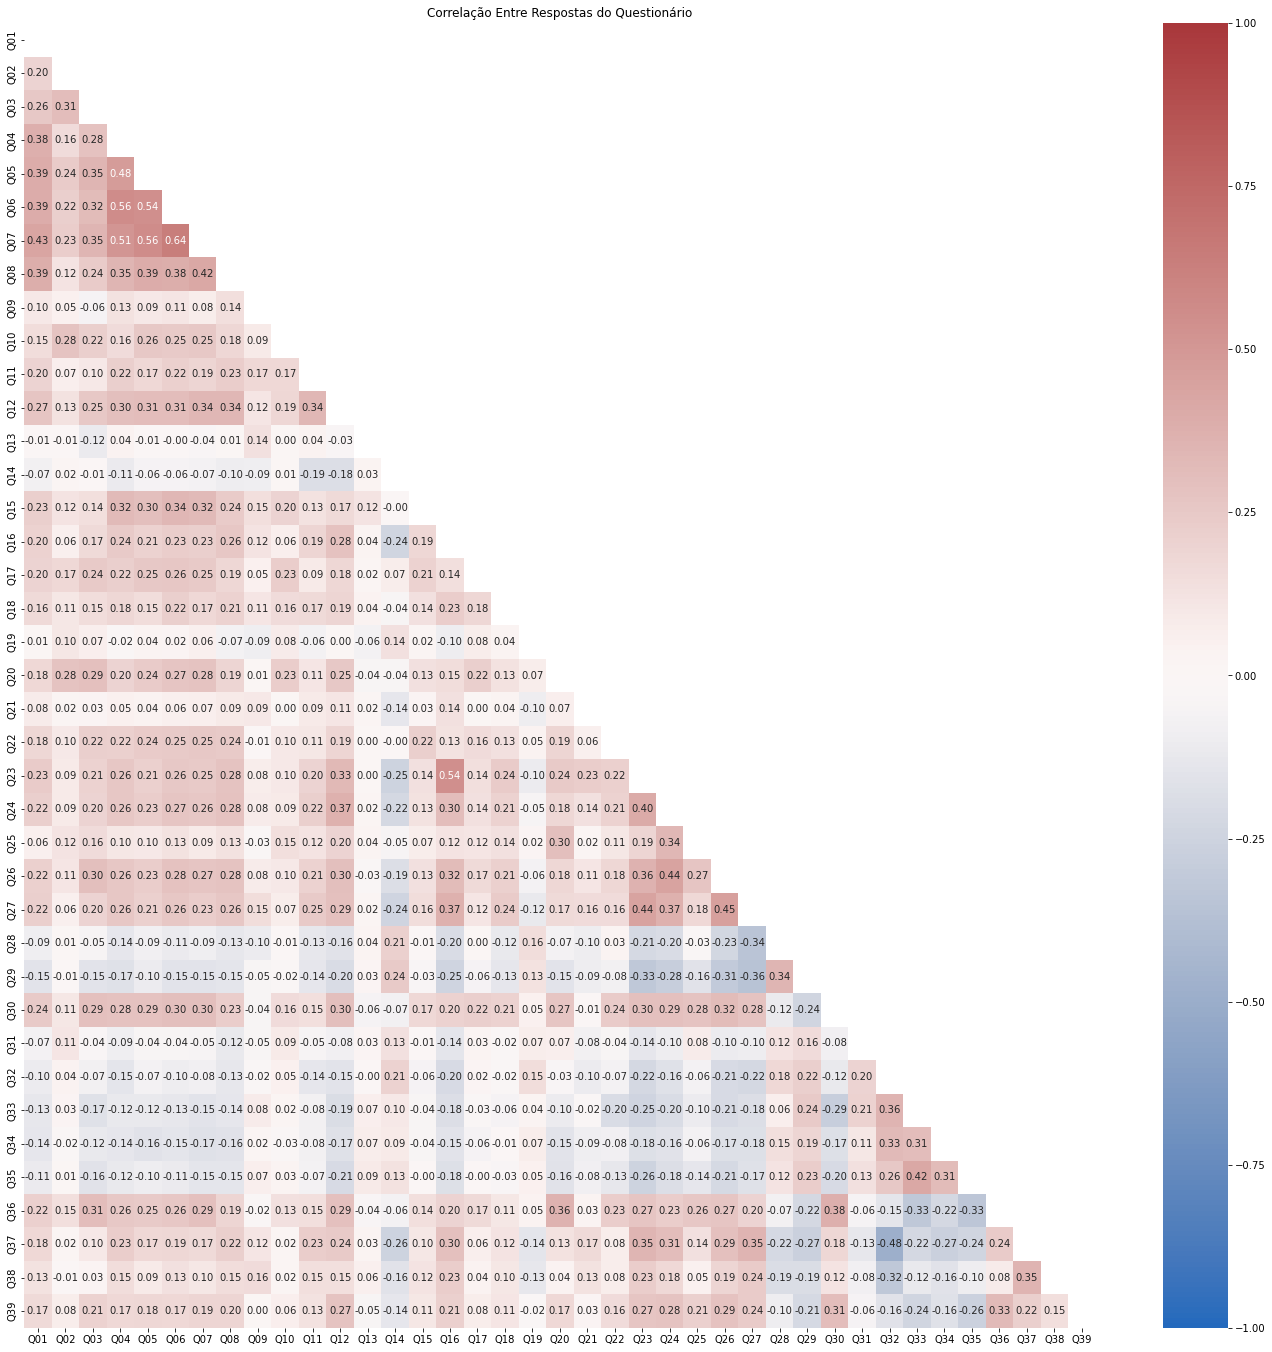

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 24))

data = df_ae.iloc[:, -39:]
data.columns = [f"Q{x+1:02}" for x in range(len(data.columns))]

mask = np.triu(np.ones(data.corr().shape, dtype=np.bool_))
g = sns.heatmap(
    data.corr(), mask=mask, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="vlag"
)
g.set_title("Correlação Entre Respostas do Questionário")
g.get_figure().savefig("../figures/corr_questionario.pdf")


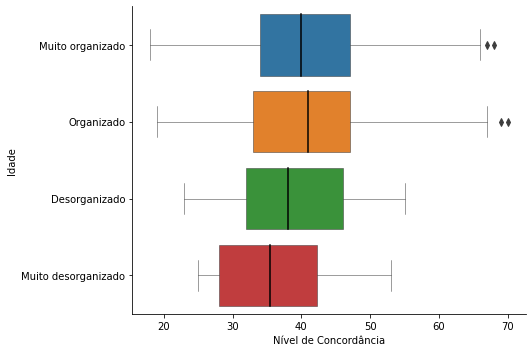

In [119]:
data = df_ae[df_ae["idade"].notna() & df_ae["organizacaocurso"].notna()]

g = sns.catplot(
    data=data,
    y="organizacaocurso",
    x="idade",
    aspect=1.5,
    kind="box",
    orient="h",
    linewidth=0.5,
    medianprops={"linewidth": 1.5, "color": "black"},
)
g.axes[0, 0].set_xlabel("Nível de Concordância")
g.axes[0, 0].set_ylabel("Idade")
g.savefig("../figures/organizacao_vs_idade.pdf")
